In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\kwanm\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

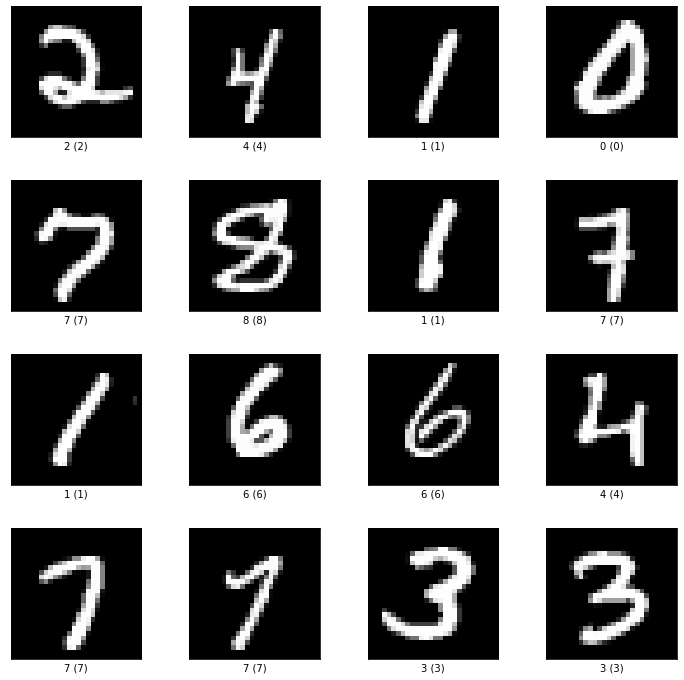

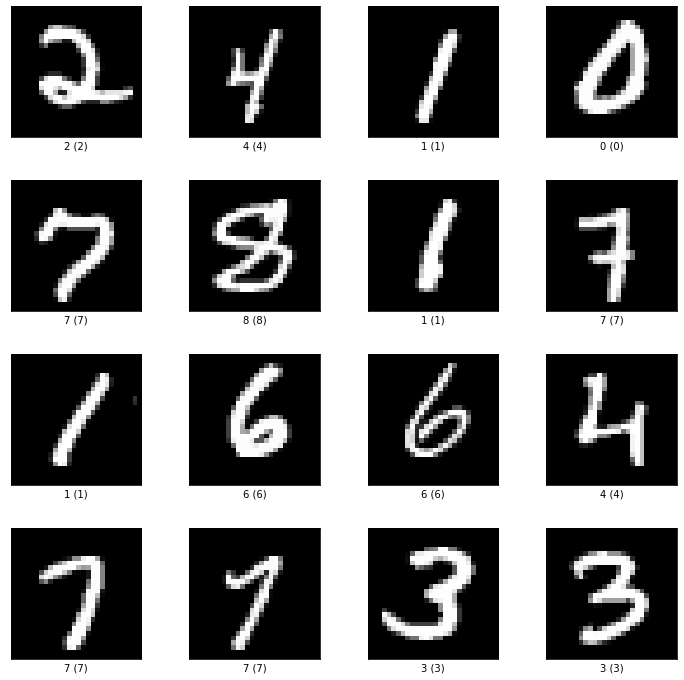

In [4]:
tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [5]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32)/255.0, label

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [7]:
model = keras.Sequential([
    keras.Input((28,28,1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
             optimizer=keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

model.fit(ds_train, epochs=5)
model.evaluate(ds_test)

Epoch 1/5
938/938 [==============================] - 12s 4ms/step - loss: 0.4009 - accuracy: 0.8870
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0790 - accuracy: 0.9774
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0498 - accuracy: 0.9854
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0385 - accuracy: 0.9887
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.9794


[0.06681510806083679, 0.9793999791145325]

In [8]:
(ds2_train, ds2_test), ds2_info = tfds.load(
    'imdb_reviews',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

ds2_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\kwanm\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo num_examples=2500

In [9]:
for text,label in ds2_train:
    print(text, label)
    import sys
    sys.exit()

tf.Tensor(b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)


SystemExit: 

C:\Users\kwanm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#TOKENIZATION
tokenizer = tfds.deprecated.text.Tokenizer()

def build_vocabulary():
    vocab = set()
    for text,_ in ds2_train:
        vocab.update(tokenizer.tokenize(text.numpy().lower()))
    return vocab

vocabulary = build_vocabulary()

encoder = tfds.deprecated.text.TokenTextEncoder(
    vocabulary, oov_token='<UNK>', lowercase=True, tokenizer=tokenizer)
                #oov = out of vocabulary

def my_encoding(text_tensor, label):
    return encoder.encode(text_tensor.numpy()), label

def encode_map(text, label):
    encoded_text, label = tf.py_function(
        my_encoding, inp=[text, label], Tout=(tf.int64, tf.int64))
    
    encoded_text.set_shape([None])
    label.set_shape([])
    
    return encoded_text, label

ds2_train = ds2_train.map(encode_map, num_parallel_calls=AUTOTUNE).cache()
ds2_train = ds2_train.shuffle(10000)
ds2_train = ds2_train.padded_batch(32, padded_shapes=([None],()))
ds2_train = ds2_train.prefetch(AUTOTUNE)

ds2_test = ds2_test.map(encode_map)
ds2_test = ds2_test.padded_batch(32, padded_shapes=([None],()))

model2 = keras.Sequential([
    layers.Masking(mask_value=0),
    layers.Embedding(input_dim=len(vocabulary)+2, output_dim=32),
    #BATCH_SIZE x 1000 -> BATCH_SIZE x 1000 x 32
    layers.GlobalAveragePooling1D(),
    #BATCH_SIZE x 32
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') #<0 -ve, >=0 +ve
])

model2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=['accuracy'])

model2.fit(ds2_train, epochs=10)
model2.evaluate(ds2_test)